In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions.normal import Normal
from torch.distributions.beta import Beta
from torch.distributions.gamma import Gamma

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Simple GAN to learn a normal distribution w.r.t. one feature -- Age

In [2]:
data_mean = 5
data_stddev = 1

Feature_Size = 1 

Hidden_Size = 10

# Generator 
g_input_size = Feature_Size 
g_hidden_size = Hidden_Size 
g_output_size = Feature_Size

# Discriminator dimension 
d_input_size = Feature_Size
d_hidden_size = Hidden_Size 
d_output_size = 1

In [3]:
d_sample_size = 1000
g_sample_size = 1000

num_epochs = 5000
print_interval = 500

d_learning_rate = 0.0005
g_learning_rate = 0.0005

In [4]:
def get_real_sampler(mu, sigma):
    dist = Beta( 1., 5. )
    return lambda m, n: dist.sample( (m, n) ).requires_grad_() # real sample with size of m x n 

def get_noise_sampler():
    return lambda m, n: torch.rand(m, n).requires_grad_()  # fake sample with size of m x n 

def get_noise_sampler_normal():
    dist = Normal( 0, 1 )
    return lambda m,n: dist.sample( (m, n) ).requires_grad_() # Standard-Normal-dist into generator

actual_data = get_real_sampler( data_mean, data_stddev )
#noise_data  = get_noise_sampler()
noise_data  = get_noise_sampler_normal()

## Real Data ~ N( 5, 1 ) with one feature -- Age 

In [5]:
real_data = actual_data( d_sample_size, d_input_size )
real = real_data.detach().numpy()
real.shape

(1000, 1)

Text(0.5, 1.0, 'Real Data -- Age')

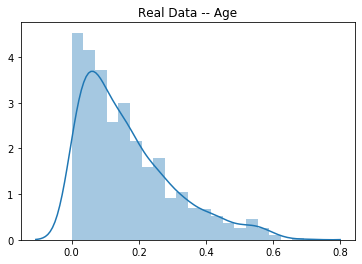

In [6]:
sns.distplot(real[:,0]).set_title('Real Data -- Age') # one sample curve 

In [7]:
np.mean(real)

0.16511677

In [8]:
np.std(real)

0.13793522

## Noise ~ N( 0, 1 ) with one feature -- Age

torch.Size([1000, 1])


Text(0.5, 1.0, 'Noise Distribution -- Age')

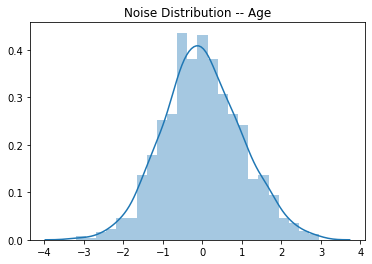

In [9]:
noise_d = noise_data( d_sample_size, g_input_size )
print(noise_d.shape)
noi = noise_d.detach().numpy()

sns.distplot(noi[:,0]).set_title('Noise Distribution -- Age') # one noise curve 

In [10]:
class Generator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Generator, self).__init__()
        self.map1 = nn.Linear(input_size, hidden_size)
        self.map2 = nn.Linear(hidden_size, hidden_size)
        self.mape = nn.Linear(hidden_size, hidden_size)
        self.map3 = nn.Linear(hidden_size, output_size)
        self.xfer = torch.nn.SELU()
    def forward(self, x):
        x = self.xfer( self.map1(x) )
        x = self.xfer( self.map2(x) )
        x = self.xfer( self.mape(x) )
        return torch.sigmoid( self.map3( x ) )
    
    
class Discriminator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Discriminator, self).__init__()
        self.map1 = nn.Linear(input_size, hidden_size)
        self.map2 = nn.Linear(hidden_size, hidden_size)
        self.mape = nn.Linear(hidden_size, hidden_size)
        self.map3 = nn.Linear(hidden_size, output_size)
        self.elu = torch.nn.ELU()
    def forward(self, x):
        x = self.elu(self.map1(x))
        x = self.elu(self.map2(x))
        x = self.elu(self.mape(x))
        return torch.sigmoid( self.map3(x) )

### We use the Adam Optimizer with smaller learning rate.

In [11]:
G = Generator(input_size=g_input_size, hidden_size=g_hidden_size, output_size=g_output_size)
D = Discriminator(input_size=d_input_size, hidden_size=d_hidden_size, output_size=d_output_size)

criterion = nn.BCELoss()
d_optimizer = optim.Adam(D.parameters(), lr=d_learning_rate ) #d_optimizer only trains D.parameters()
g_optimizer = optim.Adam(G.parameters(), lr=g_learning_rate ) 

In [12]:
def train_D_on_actual() :
    real_data = actual_data( d_sample_size, d_input_size )
    real_decision = D( real_data ) 
    real_error = criterion( real_decision, torch.ones( d_sample_size, 1 ))  # ones = true
    real_error.backward()
    return real_error.item()
    
def train_D_on_generated() :
    noise = noise_data( g_sample_size, g_input_size )
    fake_data = G( noise ) 
    fake_decision = D( fake_data )
    fake_error = criterion( fake_decision, torch.zeros( g_sample_size, 1 ))  # zeros = fake，
    fake_error.backward()
    return fake_error.item()
    
def train_G():
    noise = noise_data( g_sample_size, g_input_size )
    fake_data = G( noise )
    fake_decision = D( fake_data )
    error = criterion( fake_decision, torch.ones( g_sample_size, 1 ) ) 
    error.backward()
    return error.item(), fake_data

In [13]:
losses = []
for epoch in range(num_epochs):
    D.zero_grad()
    
    # print (G.parameters().grad)
    loss_d_real = train_D_on_actual()    
    loss_d_fake = train_D_on_generated()
    # print (G.parameters().grad)
    d_optimizer.step()
    
    G.zero_grad()
    loss_g,generated = train_G()
    #mode_score(generated, real)
    g_optimizer.step()
    
    
    losses.append( loss_g )
    if( epoch % print_interval) == (print_interval-1) :
        print( "Epoch %6d. Loss_d %5.3f. Loss_g %5.3f" % ( epoch+1, loss_d_real + loss_d_fake, loss_g) )
        #print( "Epoch %6d. Loss_g %5.3f" % ( epoch+1, loss_g ) )
        
print( "Training complete" )


Epoch    500. Loss_d 1.473. Loss_g 0.677
Epoch   1000. Loss_d 1.377. Loss_g 0.686
Epoch   1500. Loss_d 1.336. Loss_g 0.761
Epoch   2000. Loss_d 1.358. Loss_g 0.728
Epoch   2500. Loss_d 1.377. Loss_g 0.684
Epoch   3000. Loss_d 1.392. Loss_g 0.749
Epoch   3500. Loss_d 1.358. Loss_g 0.687
Epoch   4000. Loss_d 1.299. Loss_g 0.769
Epoch   4500. Loss_d 1.366. Loss_g 0.685
Epoch   5000. Loss_d 1.611. Loss_g 0.694
Training complete


# Test

In [14]:
noise=noise_data( 1000, Feature_Size)
print(noise.shape)
generated_data = G(noise)
d = generated_data.detach().numpy()
print(d.shape)

torch.Size([1000, 1])
(1000, 1)


In [15]:
d_data = D (generated_data)
d_data = d_data.detach().numpy()
print(d_data)

[[0.5588376 ]
 [0.5141053 ]
 [0.46695805]
 [0.55763453]
 [0.46000764]
 [0.5464466 ]
 [0.46911046]
 [0.5189275 ]
 [0.5395053 ]
 [0.48437345]
 [0.5571696 ]
 [0.50539315]
 [0.47271845]
 [0.46242654]
 [0.5463684 ]
 [0.51302373]
 [0.4784726 ]
 [0.46246472]
 [0.49165422]
 [0.5230791 ]
 [0.5341487 ]
 [0.45863396]
 [0.53413075]
 [0.489436  ]
 [0.5499449 ]
 [0.4749378 ]
 [0.47686833]
 [0.5365923 ]
 [0.5630163 ]
 [0.5073527 ]
 [0.48842   ]
 [0.45658138]
 [0.5436484 ]
 [0.48177165]
 [0.4823199 ]
 [0.5074939 ]
 [0.46335077]
 [0.53259474]
 [0.5315476 ]
 [0.51056   ]
 [0.48534578]
 [0.46051264]
 [0.4936826 ]
 [0.5528063 ]
 [0.46971488]
 [0.4622841 ]
 [0.46286628]
 [0.48661363]
 [0.4749279 ]
 [0.46112698]
 [0.52172816]
 [0.52362263]
 [0.47732008]
 [0.4613169 ]
 [0.5237999 ]
 [0.55119103]
 [0.47661474]
 [0.4800636 ]
 [0.54170173]
 [0.5156787 ]
 [0.46727356]
 [0.49081066]
 [0.46277818]
 [0.5477768 ]
 [0.51908123]
 [0.47454587]
 [0.48138604]
 [0.5365217 ]
 [0.4742203 ]
 [0.536606  ]
 [0.5494339 ]
 [0.54

In [16]:
# train D by D(generated) and D(real_data) to classify  
# logistic regression to classify (score of D(generated) v.s. D(real_data))

In [17]:
real_d = D (real_data)
real_d = real_d.detach().numpy()
print(real_d)

[[0.36876464]
 [0.42332312]
 [0.35918358]
 [0.36862698]
 [0.37760243]
 [0.36480415]
 [0.39306697]
 [0.39965397]
 [0.5550988 ]
 [0.36359662]
 [0.4079411 ]
 [0.3725558 ]
 [0.37735942]
 [0.46529415]
 [0.37178805]
 [0.3733772 ]
 [0.3858178 ]
 [0.37915155]
 [0.3631307 ]
 [0.35894397]
 [0.38113773]
 [0.47725466]
 [0.42850897]
 [0.43169886]
 [0.37180954]
 [0.45275205]
 [0.37490746]
 [0.41421846]
 [0.39794183]
 [0.35687697]
 [0.43218112]
 [0.38981825]
 [0.37945163]
 [0.5157792 ]
 [0.3687302 ]
 [0.41397303]
 [0.38103658]
 [0.38081625]
 [0.37897775]
 [0.36592513]
 [0.45741516]
 [0.382108  ]
 [0.3881679 ]
 [0.4799163 ]
 [0.49680436]
 [0.42302987]
 [0.36776116]
 [0.43523955]
 [0.43063745]
 [0.4030028 ]
 [0.3699582 ]
 [0.4950579 ]
 [0.45232916]
 [0.39631134]
 [0.37367097]
 [0.37571108]
 [0.3696059 ]
 [0.42173463]
 [0.4296942 ]
 [0.38375112]
 [0.4654403 ]
 [0.5342444 ]
 [0.3826129 ]
 [0.37796274]
 [0.41461772]
 [0.39353418]
 [0.43657127]
 [0.37023133]
 [0.36027458]
 [0.39215267]
 [0.5085143 ]
 [0.48

# Visualization -- Generated Age Distribution


Text(0.5, 1.0, 'Generated Age Distribution')

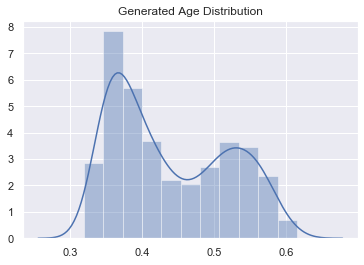

In [18]:
sns.set(color_codes=True)
sns.distplot(d[:,0]).set_title('Generated Age Distribution')

In [19]:
np.mean(d)

0.4391851

In [20]:
np.std(d)

0.07946142